
# <Center><u>CUSTOMER LIFETIME VALUE PREDICTION<center></u>
    

<center> Project Work<center>
<Center>Course: DATA 228 - Big Data Tech and App
<center>Submitted by : Gayathri Sundareshwar, Keerthana Gopikrishnan, Razan Dababo<Center>
<center>April 22nd 2022<center>

## <center><u> PACKAGES REQUIRED </u></center>

### <u>Install these packages if it is not present in the system </u>

pip install xgboost

pip install lifetimes

pip install plotly

pip install pyspark==3.2.0

conda install -c conda-forge ipyleaflet

## <CENTER><U> IMPORTING BASIC NECESSDARY PACKAGES</U></CENTER>

In [1]:
import pyspark

from pyspark import *
from pyspark.sql import *
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import sys
import re
import warnings
sc=SparkContext.getOrCreate()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import xlrd
import lifetimes
import datetime
warnings.filterwarnings("ignore")
np.random.seed(42)
from datetime import datetime, timedelta,date

In [3]:

from sklearn.metrics import classification_report,confusion_matrix
from __future__ import division
from sklearn.cluster import KMeans
# Implement learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection as cross_validation
from time import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import xgboost as xgb
plt.style.use("ggplot")

In [4]:
sc=SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

## <CENTER><U> READING INPUT DATA </CENTER></U>

### <u>Reading data from file 1 (contains data of year 2009-2010) </u>

In [5]:
input_data1 = spark.read.csv("online_retail_file_1.csv", sep =',', header = True)
input_data1.count()

525461

### <u>Reading data from file 2 (contains data of year 2010-2011) </u>

In [6]:
input_data2 = spark.read.csv("online_retail_file_2.csv", sep =',', header = True)
input_data2.count()

541910

### <u> Combine both the dataframes into single dataframe</u>

In [7]:
spark_data=input_data1.unionAll(input_data2)

In [8]:
spark_data.count()

1067371

In [9]:
spark_data.columns

['Invoice',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'Price',
 'Customer ID',
 'Country']

In [10]:
data=spark_data.toPandas()

In [11]:
data.dtypes

Invoice        object
StockCode      object
Description    object
Quantity       object
InvoiceDate    object
Price          object
Customer ID    object
Country        object
dtype: object

## <center><u>DATA WRANGLING</center></u>

Data wrangling is an essential part of carving meaningful insights out of massive amounts of data. Data wrangling refers to a variety of processes designed to transform raw data into more readily used formats. 
Each data project requires a unique approach to ensure its final dataset is reliable and accessible.
Data cleaning is the process of removing inherent errors in data that might distort our analysis or render it less valuable. Cleaning can come in different forms, including deleting empty cells or rows, removing outliers, and standardizing inputs. The goal of data cleaning is to ensure there are no errors (or as few as possible) that could influence our final analysis.<br>
Let us now clease the data by performing data wrangling operations such as removing nulls, dropping duplicates, assigning right column names etc.

### <u>Assigning the right datatypes for columns</u>

In [12]:
data.Quantity = data.Quantity.astype('int64')
data.InvoiceDate = data.InvoiceDate.astype('datetime64[ns]')
data.Price = data.Price.astype('float64')
data['Customer ID'] = data['Customer ID'].astype('float64')

In [13]:
data.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

### <u>Printing the number of unique customers present </u>

In [14]:
print("Number of Unique Customers:", data['Customer ID'].nunique())

Number of Unique Customers: 5942


### <u>Checking the presence of duplicates </u>

In [15]:
#checking duplicates
print(f"there are {data.duplicated().sum()} duplicated rows")

there are 34335 duplicated rows


In [16]:
#viewing duplicated rows
data[data.duplicated()].head(10)

Invoice StockCode                        Description  Quantity  \
371  489517     21912           VINTAGE SNAKES & LADDERS         1   
383  489517     22130   PARTY CONE CHRISTMAS DECORATION          6   
384  489517     22319  HAIRCLIPS FORTIES FABRIC ASSORTED        12   
385  489517     21913     VINTAGE SEASIDE JIGSAW PUZZLES         1   
386  489517     21821   GLITTER STAR GARLAND WITH BELLS          1   
390  489517    84951A    S/4 PISTACHIO LOVEBIRD COASTERS         1   
391  489517     21491    SET OF THREE VINTAGE GIFT WRAPS         1   
394  489517     21912           VINTAGE SNAKES & LADDERS         1   
657  489529     22028       PENNY FARTHING BIRTHDAY CARD        12   
658  489529     22036             DINOSAUR BIRTHDAY CARD        12   

            InvoiceDate  Price  Customer ID         Country  
371 2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
383 2009-12-01 11:34:00   0.85      16329.0  United Kingdom  
384 2009-12-01 11:34:00   0.65      16329.0  United Kingdom  
385 2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
386 2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
390 2009-12-01 11:34:00   2.55      16329.0  United Kingdom  
391 2009-12-01 11:34:00   1.95      16329.0  United Kingdom  
394 2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
657 2009-12-01 11:51:00   0.42      17984.0  United Kingdom  
658 2009-12-01 11:51:00   0.42      17984.0  United Kingdom

### <u>Dropping duplicate records </u>

In [17]:
data = data.drop_duplicates(keep='first')

### <u>Checking the presence of null values </u>

In [18]:
data.isnull().sum()/data.shape[0]*100

Invoice         0.000000
StockCode       0.000000
Description     0.413829
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.763098
Country         0.000000
dtype: float64

### <u>Dropping rows with null values in Description columns</u>

In [19]:
# first drop the rows where the description is null
data.dropna(axis = 0, subset = ["Description"], inplace = True)

In [20]:
data.isnull().sum() #Now let's check the data before droping these customer ID's

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    230876
Country             0
dtype: int64

### <u>Dropping rows with null values in Customer ID columns</u>

In [21]:
data[data["Customer ID"].isnull()]

Invoice StockCode                     Description  Quantity  \
263      489464     21733                    85123a mixed       -96   
283      489463     71477                           short      -240   
284      489467    85123A                     21733 mixed      -192   
577      489525    85226C       BLUE PULL BACK RACING CAR         1   
578      489525     85227     SET/6 3D KIT CARDS FOR KIDS         1   
...         ...       ...                             ...       ...   
1066997  581498    85099B         JUMBO BAG RED RETROSPOT         5   
1066998  581498    85099C  JUMBO  BAG BAROQUE BLACK WHITE         4   
1066999  581498     85150   LADIES & GENTLEMEN METAL SIGN         1   
1067000  581498     85174               S/4 CACTI CANDLES         1   
1067001  581498       DOT                  DOTCOM POSTAGE         1   

                InvoiceDate    Price  Customer ID         Country  
263     2009-12-01 10:52:00     0.00          NaN  United Kingdom  
283     2009-12-01 10:52:00     0.00          NaN  United Kingdom  
284     2009-12-01 10:53:00     0.00          NaN  United Kingdom  
577     2009-12-01 11:49:00     0.55          NaN  United Kingdom  
578     2009-12-01 11:49:00     0.85          NaN  United Kingdom  
...                     ...      ...          ...             ...  
1066997 2011-12-09 10:26:00     4.13          NaN  United Kingdom  
1066998 2011-12-09 10:26:00     4.13          NaN  United Kingdom  
1066999 2011-12-09 10:26:00     4.96          NaN  United Kingdom  
1067000 2011-12-09 10:26:00    10.79          NaN  United Kingdom  
1067001 2011-12-09 10:26:00  1714.17          NaN  United Kingdom  

[230876 rows x 8 columns]

In [22]:
data.iloc[575:, :]

Invoice StockCode                         Description  Quantity  \
584      489526     84948  SILVER HANGING T-LIGHT HOLDER DOME        24   
585      489526     21537            RETRO SPOTS PUDDING BOWL         4   
586      489526     21733    RED HANGING HEART T-LIGHT HOLDER         6   
587      489526    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
588      489526     20718              RED SPOTTY SHOPPER BAG        10   
...         ...       ...                                 ...       ...   
1067366  581587     22899        CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587     23254       CHILDRENS CUTLERY DOLLY GIRL          4   
1067368  581587     23255     CHILDRENS CUTLERY CIRCUS PARADE         4   
1067369  581587     22138       BAKING SET 9 PIECE RETROSPOT          3   
1067370  581587      POST                             POSTAGE         1   

                InvoiceDate  Price  Customer ID  Country  
584     2009-12-01 11:50:00   1.65      12533.0  Germany  
585     2009-12-01 11:50:00   4.25      12533.0  Germany  
586     2009-12-01 11:50:00   2.95      12533.0  Germany  
587     2009-12-01 11:50:00   2.95      12533.0  Germany  
588     2009-12-01 11:50:00   1.25      12533.0  Germany  
...                     ...    ...          ...      ...  
1067366 2011-12-09 12:50:00   2.10      12680.0   France  
1067367 2011-12-09 12:50:00   4.15      12680.0   France  
1067368 2011-12-09 12:50:00   4.15      12680.0   France  
1067369 2011-12-09 12:50:00   4.95      12680.0   France  
1067370 2011-12-09 12:50:00  18.00      12680.0   France  

[1028186 rows x 8 columns]

In [23]:
# We have to drop the rows where customer ID is null because it's a unique customer ID of each customer
# So it's better to drop rather than imputing it with some random value

data.dropna(axis = 0, subset = ["Customer ID"], inplace = True)

In [24]:
data.isnull().sum() #Now's there is no null values available in our data

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [25]:
data.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

### <u> Removing rows with negative values for quantity </u>

In [26]:
data.loc[data['Quantity']<0]

Invoice StockCode                       Description  Quantity  \
178      C489449     22087          PAPER BUNTING WHITE LACE       -12   
179      C489449    85206A      CREAM FELT EASTER EGG BASKET        -6   
180      C489449     21895     POTTING SHED SOW 'N' GROW SET        -4   
181      C489449     21896                POTTING SHED TWINE        -6   
182      C489449     22083        PAPER CHAIN KIT RETRO SPOT       -12   
...          ...       ...                               ...       ...   
1065910  C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
1067002  C581499         M                            Manual        -1   
1067176  C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
1067177  C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
1067178  C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

                InvoiceDate   Price  Customer ID         Country  
178     2009-12-01 10:33:00    2.95      16321.0       Australia  
179     2009-12-01 10:33:00    1.65      16321.0       Australia  
180     2009-12-01 10:33:00    4.25      16321.0       Australia  
181     2009-12-01 10:33:00    2.10      16321.0       Australia  
182     2009-12-01 10:33:00    2.95      16321.0       Australia  
...                     ...     ...          ...             ...  
1065910 2011-12-09 09:57:00    0.83      14397.0  United Kingdom  
1067002 2011-12-09 10:28:00  224.69      15498.0  United Kingdom  
1067176 2011-12-09 11:57:00   10.95      15311.0  United Kingdom  
1067177 2011-12-09 11:58:00    1.25      17315.0  United Kingdom  
1067178 2011-12-09 11:58:00    1.25      17315.0  United Kingdom  

[18390 rows x 8 columns]

In [27]:
data = data.loc[data['Quantity'] > 0]

In [28]:
# Let's check negative records
data[data['Quantity'] < 0]

Empty DataFrame
Columns: [Invoice, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, Country]
Index: []

In [29]:
data.head(10)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041      "RECORD FRAME 7"" SINGLE SIZE "        48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
5  489434     22064           PINK DOUGHNUT TRINKET POT         24   
6  489434     21871                  SAVE THE PLANET MUG        24   
7  489434     21523   FANCY FONT HOME SWEET HOME DOORMAT        10   
8  489435     22350                            CAT BOWL         12   
9  489435     22349       DOG BOWL , CHASING BALL DESIGN        12   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
5 2009-12-01 07:45:00   1.65      13085.0  United Kingdom  
6 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
7 2009-12-01 07:45:00   5.95      13085.0  United Kingdom  
8 2009-12-01 07:46:00   2.55      13085.0  United Kingdom  
9 2009-12-01 07:46:00   3.75      13085.0  United Kingdom

In [30]:
temp_df = pd.DataFrame(data["Country"].value_counts())

In [31]:
temp_df.head(10)

Country
United Kingdom   700434
Germany           16440
EIRE              15567
France            13512
Netherlands        5090
Spain              3663
Belgium            3056
Switzerland        3006
Portugal           2356
Australia          1792

In [32]:
data.count()

Invoice        779495
StockCode      779495
Description    779495
Quantity       779495
InvoiceDate    779495
Price          779495
Customer ID    779495
Country        779495
dtype: int64

In [33]:
names  = temp_df.index
print(names)

Index(['United Kingdom', 'Germany', 'EIRE', 'France', 'Netherlands', 'Spain',
       'Belgium', 'Switzerland', 'Portugal', 'Australia', 'Channel Islands',
       'Italy', 'Sweden', 'Norway', 'Cyprus', 'Finland', 'Austria', 'Denmark',
       'Greece', 'Unspecified', 'Poland', 'Japan', 'USA',
       'United Arab Emirates', 'Singapore', 'Israel', 'Malta', 'Canada',
       'Iceland', 'Lithuania', 'RSA', 'Brazil', 'Thailand',
       'European Community', 'Bahrain', 'West Indies', 'Korea', 'Lebanon',
       'Nigeria', 'Czech Republic', 'Saudi Arabia'],
      dtype='object')


## <center><u> DATA VISUALIZATION </u></center>

### <u>Visualizing the num of unique records per country </u>

In [34]:
px.figsize=(20,5)

fig=px.scatter(temp_df, y = "Country", color = names, title = "Transactions Per Country").update_layout(xaxis_title="Country",yaxis_title="Count")
fig.show()

In [35]:
data.head(5)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041      "RECORD FRAME 7"" SINGLE SIZE "        48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

### <u>Quantity per country</u>

In [36]:
#Now let's check the total quantity and by country
data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).head(10)

Country
United Kingdom    8545921
Netherlands        384519
EIRE               318271
France             270289
Denmark            237471
Germany            225173
Australia          104067
Sweden              88495
Switzerland         52228
Spain               50318
Name: Quantity, dtype: int64

### <u> Visualizing the countries ordered by average price high to low </u>

In [37]:
px.figsize=(20,5)
px.scatter(data.iloc[:, [5, 7]].groupby(["Country"]).mean(), 
           y = "Price", size = "Price", title = "Average Price by Country", opacity = 0.48)

From the above dot plot we can conclude that the **Singapore** has the highest averge price followed by the **Norway** and **Malta**. Let's go deeper and see the distribution to better understand about our data.

### <u> Visualizing the price distribution across countries </u>

In [38]:
countries = data["Country"].unique()

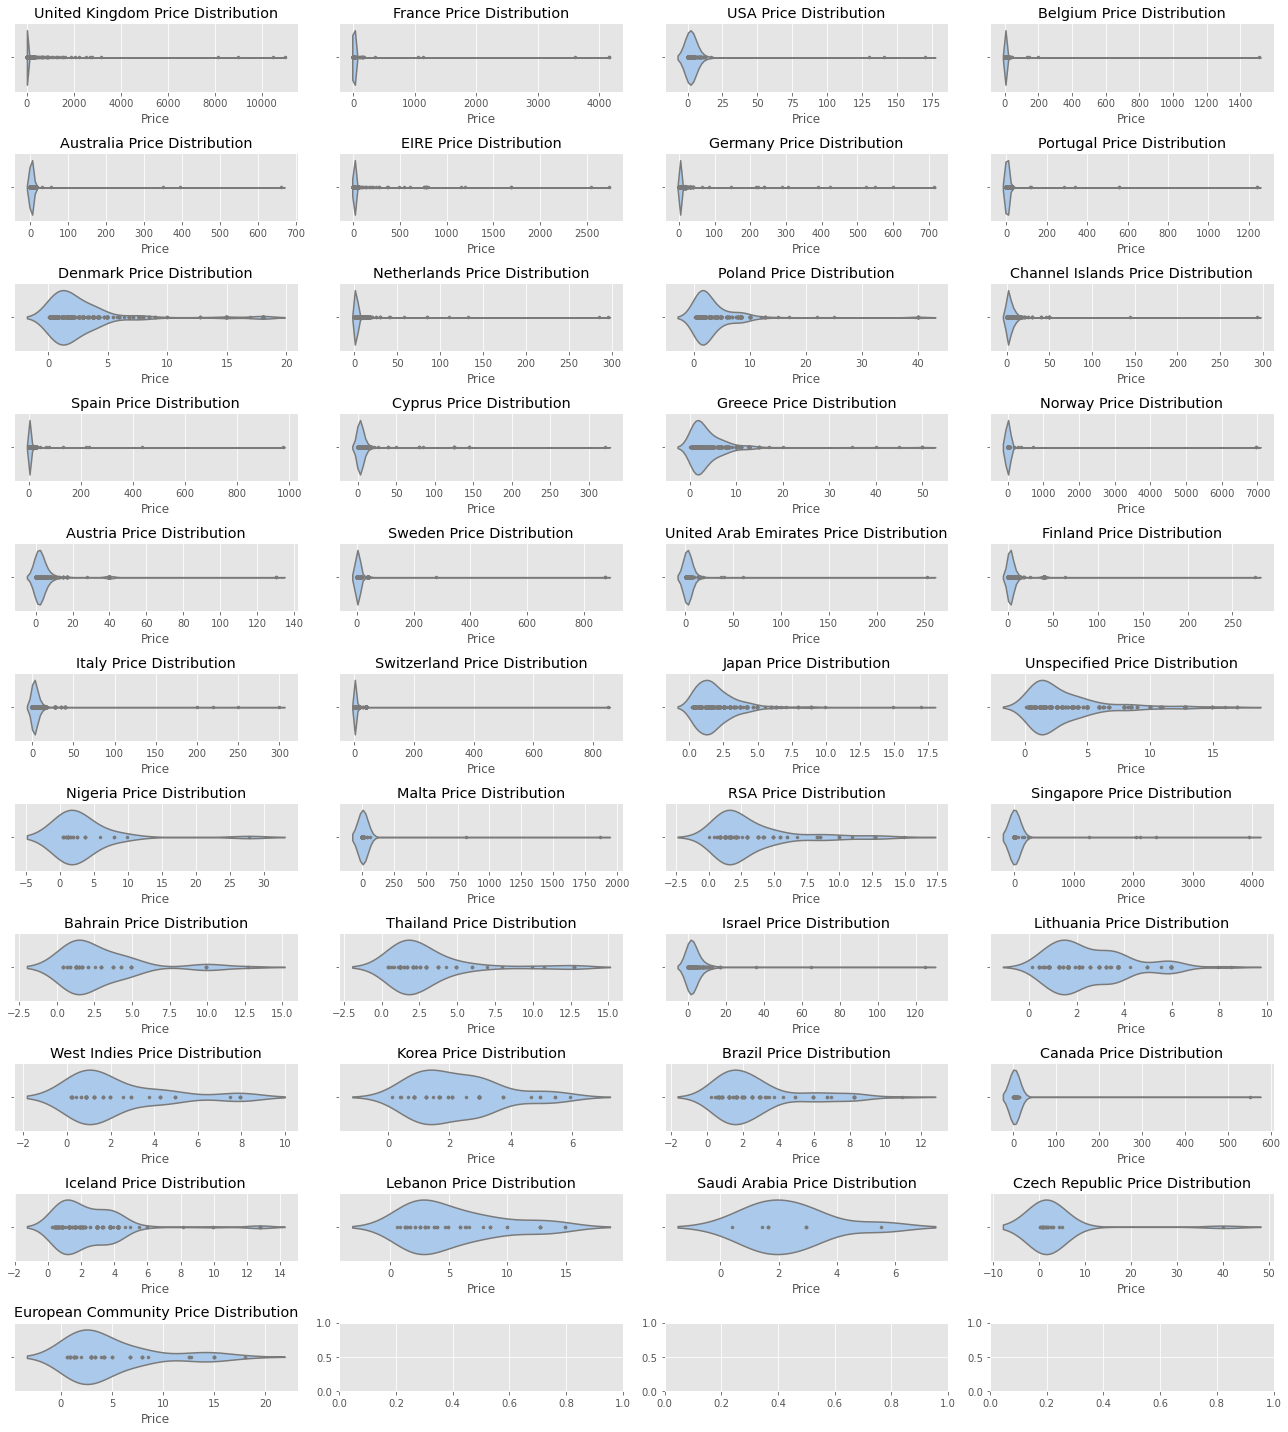

In [39]:
fig, ax = plt.subplots(11, 4, figsize=(18,20))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, c in enumerate(countries):
    sns.violinplot(x = "Price", data = data[data["Country"] == c], ax = axes_[i], inner = "point", palette = "pastel")
    axes_[i].set_title(c + ' ' + "Price Distribution")
    plt.tight_layout()

From the above plot what I can interpret is that most of the data is pretty skewed and there is lot's of high extreme values that are present in the data.

In [40]:
#Total Number of Unique Invoices 
len(data["Invoice"].unique())

36975

In [41]:
data.count()

Invoice        779495
StockCode      779495
Description    779495
Quantity       779495
InvoiceDate    779495
Price          779495
Customer ID    779495
Country        779495
dtype: int64

### <u>Grouping the data by invoice</u>

In [42]:
temp_invoice_df = data.groupby("Invoice").sum()

In [43]:
temp_invoice_df.reset_index(inplace = True)

### <u>Sorting based on quantity</u>

In [44]:
#Below are the top 30 invoices with total quantity purchased by them
temp_invoice_df.sort_values(by = "Quantity", ascending = False).head(30).iloc[:,:2].style.background_gradient(cmap = "Blues")

In [45]:
data.groupby(["Invoice"]).mean().head(15).iloc[:, [1]].sort_values("Price", ascending = False)

Price
Invoice            
489444   141.000000
489447   130.000000
489434     4.081250
489436     3.730526
489437     3.628261
489439     3.560000
489440     3.150000
489446     3.118519
489441     3.042500
489448     2.970000
489435     2.625000
489438     2.591176
489445     2.477895
489443     2.370000
489442     2.040870

## <center><u>**INITIAL INSIGHTS GATHERED**</u></center>

1) Most of the customers are from the United Kingdom followed by the Germany, EIRE & France.

2) If we check the average price sale by countries, what we have observed is that Singapore has the highest averge price sale followed by the Norway and Malta.

3) Most of the countries data is skewed when it comes to the Price feature with lots of higher extreme values.

4) There are total 36975 uniques purchased happend so far.


In [46]:
#Let's look at the data once again & see what else insights we can get from the data itself
data.head(15)

Invoice StockCode                          Description  Quantity  \
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434    79323P                   PINK CHERRY LIGHTS        12   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   
3   489434     22041      "RECORD FRAME 7"" SINGLE SIZE "        48   
4   489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
5   489434     22064           PINK DOUGHNUT TRINKET POT         24   
6   489434     21871                  SAVE THE PLANET MUG        24   
7   489434     21523   FANCY FONT HOME SWEET HOME DOORMAT        10   
8   489435     22350                            CAT BOWL         12   
9   489435     22349       DOG BOWL , CHASING BALL DESIGN        12   
10  489435     22195         HEART MEASURING SPOONS LARGE        24   
11  489435     22353   LUNCHBOX WITH CUTLERY FAIRY CAKES         12   
12  489436    48173C                DOOR MAT BLACK FLOCK         10   
13  489436     21755             LOVE BUILDING BLOCK WORD        18   
14  489436     21754             HOME BUILDING BLOCK WORD         3   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
5  2009-12-01 07:45:00   1.65      13085.0  United Kingdom  
6  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
7  2009-12-01 07:45:00   5.95      13085.0  United Kingdom  
8  2009-12-01 07:46:00   2.55      13085.0  United Kingdom  
9  2009-12-01 07:46:00   3.75      13085.0  United Kingdom  
10 2009-12-01 07:46:00   1.65      13085.0  United Kingdom  
11 2009-12-01 07:46:00   2.55      13085.0  United Kingdom  
12 2009-12-01 09:06:00   5.95      13078.0  United Kingdom  
13 2009-12-01 09:06:00   5.45      13078.0  United Kingdom  
14 2009-12-01 09:06:00   5.95      13078.0  United Kingdom

## <center><u>ADDITIONAL EXPLORATORY DATA ANALYSIS</u></center>
    

 To gain more understanding on the dataset, lets perform some more exploratory anaysis. 

<AxesSubplot:xlabel='Description'>

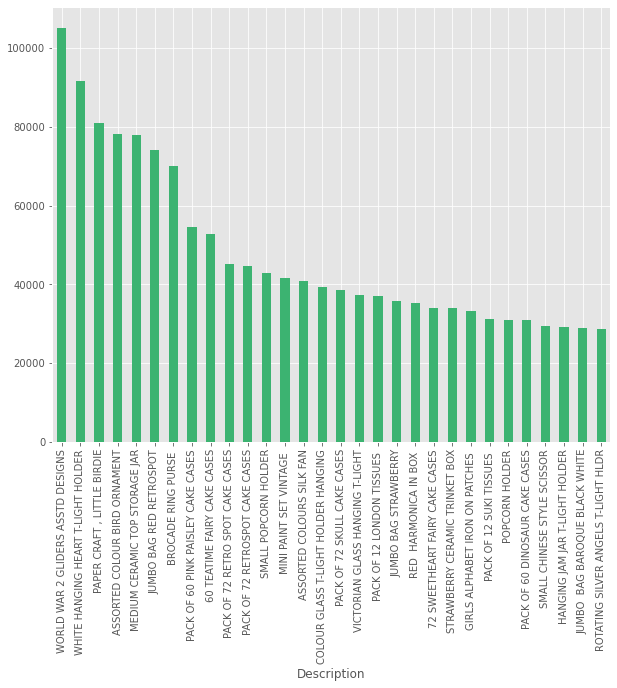

In [47]:
#Let's check which product has been purchased more often so far
plt.figure(figsize=(10,8))
data.groupby("Description").sum().sort_values(by = "Quantity", ascending = False).head(30)["Quantity"].plot(kind = "bar", color = 'mediumseagreen')

In [48]:
temp_data = data.copy()

In [49]:
temp_data.head(5)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041      "RECORD FRAME 7"" SINGLE SIZE "        48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

### <u>Date time analysis</u>

In [50]:
#Date Time Analysis
temp_data.loc[:, "Month"] = data.InvoiceDate.dt.month
temp_data.loc[:, "Time"] = data.InvoiceDate.dt.time
temp_data.loc[:, "Year"] = data.InvoiceDate.dt.year
temp_data.loc[:, "Day"] = data.InvoiceDate.dt.day
temp_data.loc[:, "Quarter"] = data.InvoiceDate.dt.quarter
temp_data.loc[:, "Day of Week"] = data.InvoiceDate.dt.dayofweek

In [51]:
#Mapping day of week
dayofweek_mapping = dict({0: "Monday", 
                         1: "Tuesday", 
                         2: "Wednesday" , 
                         3: "Thursday", 
                         4: "Friday", 
                         5: "Saturday", 
                         6: "Sunday"})

In [52]:
temp_data["Day of Week"] = temp_data["Day of Week"].map(dayofweek_mapping) 

### <u>Visualizing the transactions by month, year, day, quarter and week</u>

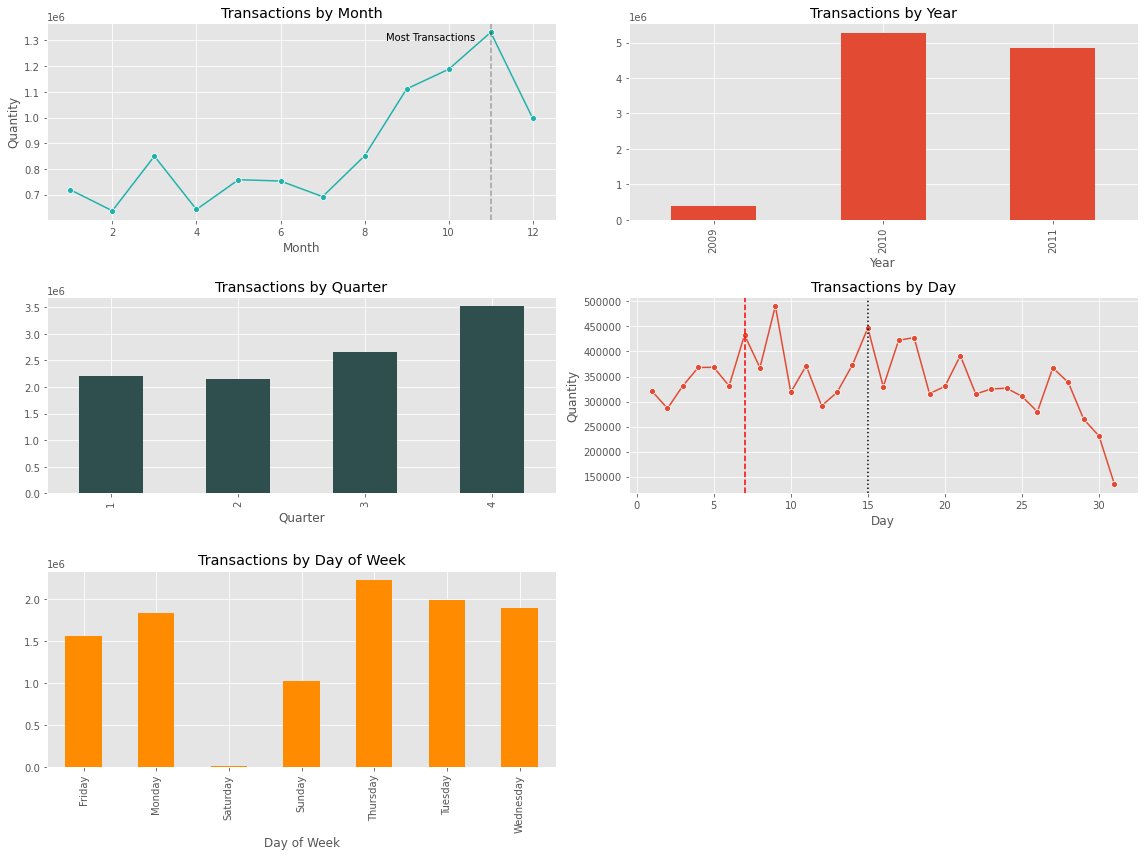

In [53]:
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
sns.lineplot(x = "Month", y = "Quantity", data = temp_data.groupby("Month").sum("Quantity"), marker = "o", color = "lightseagreen")
plt.axvline(11, color = "k", linestyle = '--', alpha = 0.3)
plt.text(8.50, 1.3e6, "Most Transactions")
plt.title("Transactions by Month")
plt.subplot(3,2,2)
temp_data.groupby("Year").sum()["Quantity"].plot(kind = "bar")
plt.title("Transactions by Year")
plt.subplot(3,2,3)
temp_data.groupby("Quarter").sum()["Quantity"].plot(kind = "bar", color = "darkslategrey")
plt.title("Transactions by Quarter")
plt.subplot(3,2,4)
sns.lineplot(x = "Day", y = "Quantity", data = temp_data.groupby("Day").sum("Quantity"), marker = "o", )
plt.axvline(7, color = 'r', linestyle = '--')
plt.axvline(15, color = 'k', linestyle = "dotted")
plt.title("Transactions by Day")
plt.subplot(3,2,5)
temp_data.groupby("Day of Week").sum()["Quantity"].plot(kind = "bar", color = "darkorange")
plt.title("Transactions by Day of Week")
plt.tight_layout()
plt.show()

As we can see, in 2009 the transactions is quite low as compared to 2010 and 2011. But as if now, we don't know the reason behind this so let's investigate why 2009 is low as compared to other 2 years.

In [54]:
print("Total Number of Countries in 2009: {}".format(len(temp_data[temp_data["Year"] == 2009]["Country"].unique())))
print("Total Number of Transactions in 2009: {}".format(temp_data[temp_data["Year"] == 2009]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2010: {}".format(len(temp_data[temp_data["Year"] == 2010]["Country"].unique())))
print("Total Number of Transactions in 2010: {}".format(temp_data[temp_data["Year"] == 2010]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2011: {}".format(len(temp_data[temp_data["Year"] == 2011]["Country"].unique())))
print("Total Number of Transactions in 2011: {}".format(temp_data[temp_data["Year"] == 2011]["Quantity"].sum()))

Total Number of Countries in 2009: 22
Total Number of Transactions in 2009: 398708
--------------------------------------------
Total Number of Countries in 2010: 37
Total Number of Transactions in 2010: 5275173
--------------------------------------------
Total Number of Countries in 2011: 36
Total Number of Transactions in 2011: 4854824


Through this analysis what conclusion we can make is that may be the company has started their operations in other countries and started to expand their business further.

In [55]:
_2009 = temp_data[temp_data["Year"] == 2009]["Country"].unique()
_2010 = temp_data[temp_data["Year"] == 2010]["Country"].unique()
_2011 = temp_data[temp_data["Year"] == 2011]["Country"].unique()

In [56]:
no_cols = []

for i in (_2010):
    if i not in _2009:
        no_cols.append(i)
print("These are the values which are not present in 2009: {}".format(no_cols))

These are the values which are not present in 2009: ['Japan', 'Unspecified', 'Nigeria', 'Malta', 'RSA', 'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland']


In [57]:
temp = data.groupby(["Country", "Description"]).sum()["Quantity"]

In [58]:
temp = pd.DataFrame(temp)

### <u>Top 8 Countries With Most Transactions</u>

In [59]:
top_8_countries = ["United Kingdom", "Germany", "EIRE", "France", "Netherlands", "Spain", "Belgium", "Switzerland"]

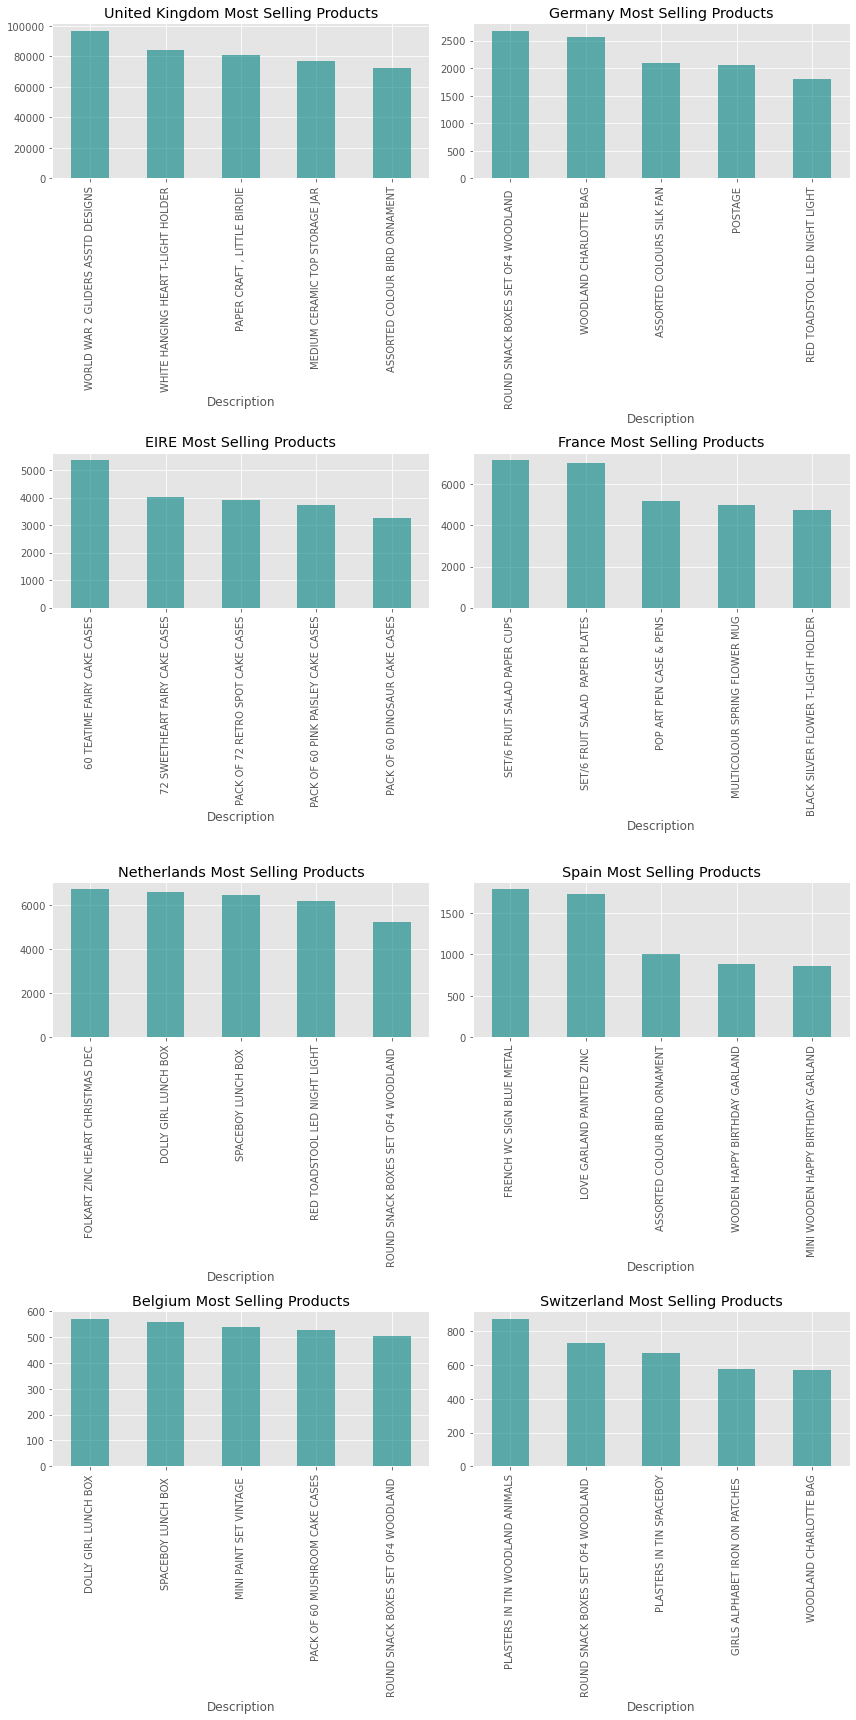

In [60]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(top_8_countries):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "teal", alpha = 0.6)
    plt.tight_layout()

### <u>Top 8 Countries With Least Transactions</u>

In [61]:
least_8_country = ["Saudi Arabia", "Czech Republic", "Nigeria", "Lebanon", "Korea", "West Indies", "Bahrain", "European Community"]

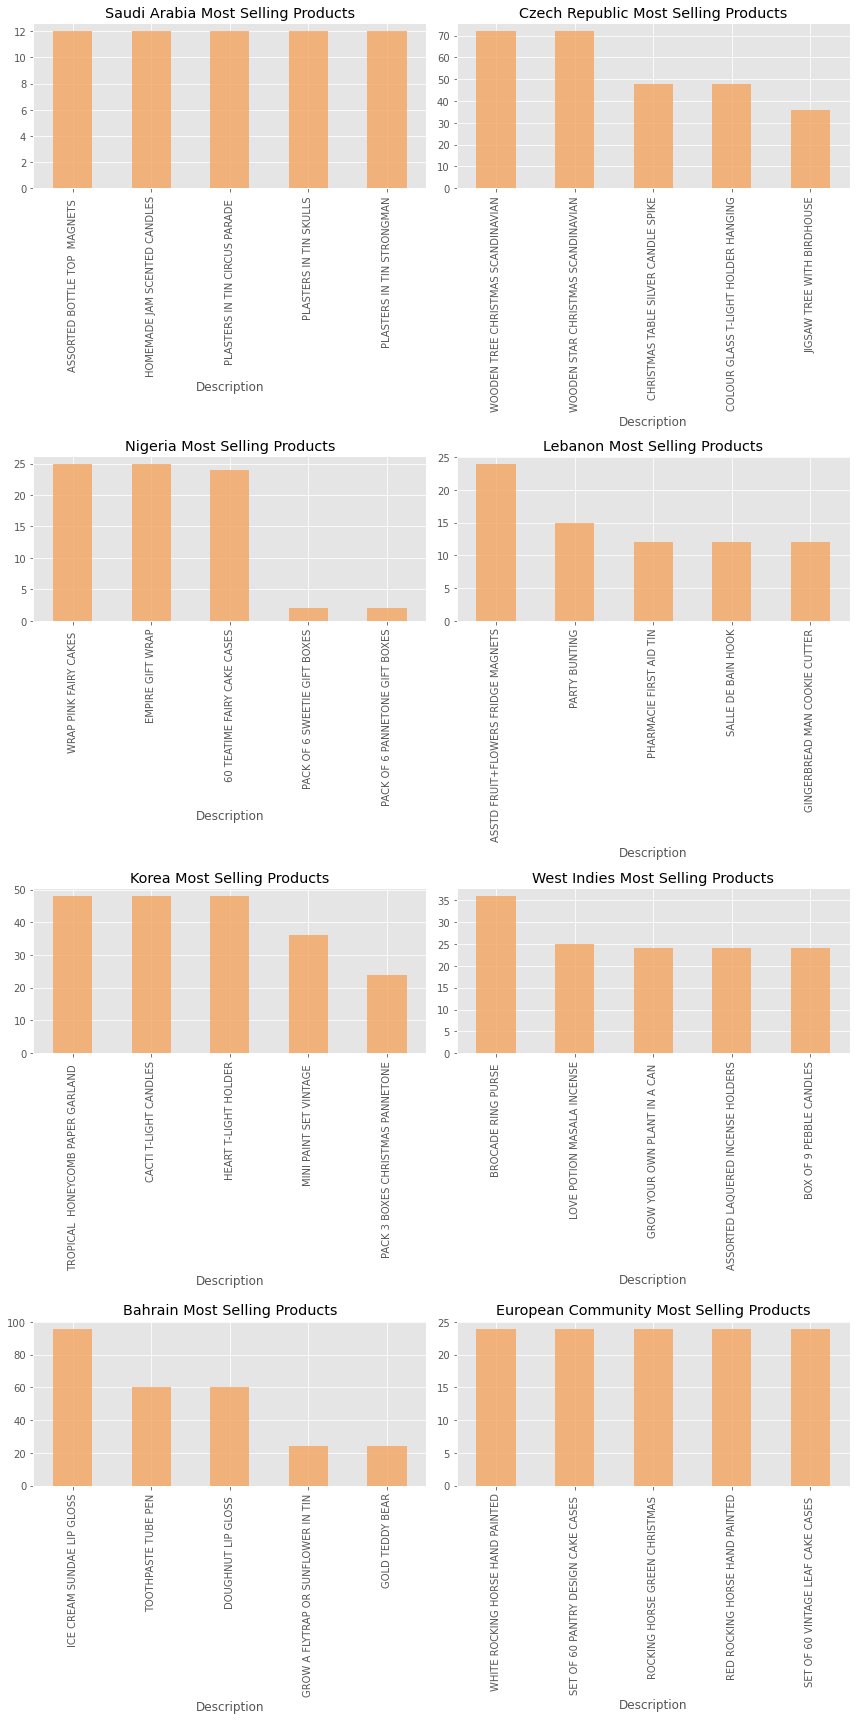

In [62]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(least_8_country):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "sandybrown", alpha = 0.8)
    
    plt.tight_layout()

### <u><center>**ADDITION INSIGHTED GATHERED THROUGH EDA**</u></center>


1) Our Top 5 Best Selling Products are **World War 2 Gliders**, **White Hanging Heart**, **paper craft**,**Assorted Colour Bird** and **Medium ceramic top storage jar**.

2) Most Transactions happened in the month of Novemeber which is evident due to festive seasons.

3) 2010 is the year in which we have the most transactions followed by the 2011

4) Q4 being the highest when it comes transactions.

5) It also observed that in the end of the 1st week and starting of the 3rd week, people tends to buy more.

6) People loves to shop on Thursday followed by Tuesday and Wednesday.


In [63]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

### <U>Creating 2 dataframes </u>
One with data from 2009-12-01 to 2010-12-01 and another with data from 2010-12-01  to 2011-12-01 

In [64]:
#create 3m and 6m dataframes
tx_3m = data[(data.InvoiceDate < '2010-12-01 00:00:00') & (data.InvoiceDate >= '2009-12-01 00:00:00')].reset_index(drop=True)
tx_6m = data[(data.InvoiceDate >= '2010-12-01 00:00:00') & (data.InvoiceDate < '2011-12-01 00:00:00')].reset_index(drop=True)

In [65]:
tx_6m.count()

Invoice        375706
StockCode      375706
Description    375706
Quantity       375706
InvoiceDate    375706
Price          375706
Customer ID    375706
Country        375706
dtype: int64

### <u> Unique customers in each new dataframe</u>

In [66]:
tx_3m['Customer ID'].nunique()

4268

In [67]:
tx_6m['Customer ID'].nunique()

4298

In [68]:
tx_user = pd.DataFrame(tx_3m['Customer ID'].unique())
tx_user.columns = ['Customer ID']

In [69]:
tx_user.count()

Customer ID    4268
dtype: int64

In [70]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [71]:
tx_user.count()

Customer ID    4268
dtype: int64

### <U> Calculating recency score and generating recency cluster through kmeans </u>

In [72]:
#calculate recency score
tx_max_purchase = tx_3m.groupby('Customer ID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['Customer ID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['Customer ID','Recency']], on='Customer ID')

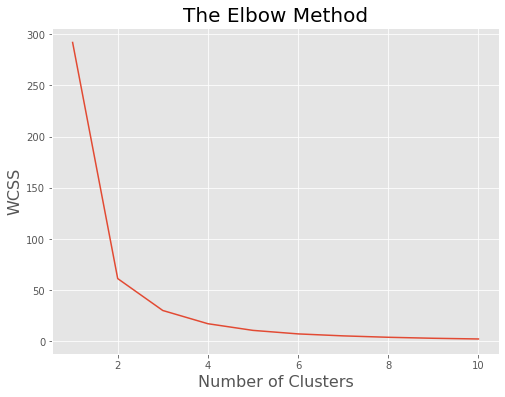

In [73]:
# Finding the best number of clusters
# Within Cluster Sum Of Squares (WCSS) measures sum of distances of observations from their cluster centroids which is given by the below formula.
# By plotting the WCSS against the the number of clusters (K Value) 
# Then we can identify the optimal number of clusters value.


#Transformation process: normalizing our values
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler((0,1))
x_scaled = min_max_scaler.fit_transform(tx_user[['Recency']])
data_scaled = pd.DataFrame(x_scaled)


plt.figure(figsize=(8,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=10, max_iter = 300)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('Number of Clusters',fontsize=16)
plt.ylabel('WCSS',fontsize=16)
plt.show()


In [74]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [75]:
tx_user.count()

Customer ID       4268
Recency           4268
RecencyCluster    4268
dtype: int64

### <U> Calculating frequency score and generating frequency cluster through kmeans</u>

In [76]:
#calcuate frequency score
tx_frequency = tx_3m.groupby('Customer ID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['Customer ID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='Customer ID')

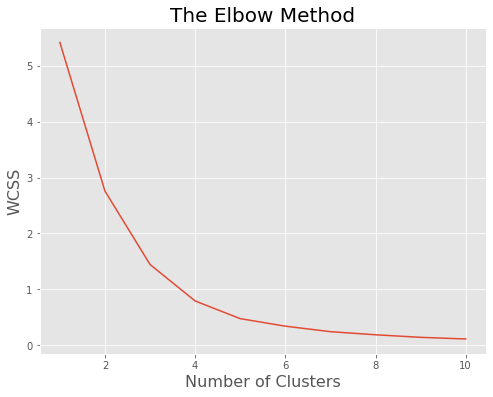

In [77]:
#Transformation process: normalizing our values
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler((0,1))
x_scaled = min_max_scaler.fit_transform(tx_user[['Frequency']])
data_scaled = pd.DataFrame(x_scaled)


plt.figure(figsize=(8,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=10, max_iter = 300)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('Number of Clusters',fontsize=16)
plt.ylabel('WCSS',fontsize=16)
plt.show()

In [78]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [79]:
tx_user.count()

Customer ID         4268
Recency             4268
RecencyCluster      4268
Frequency           4268
FrequencyCluster    4268
dtype: int64

### <u> Calculating revenue score and generating revenue cluster through kmeans </u>

In [80]:
#calcuate revenue score
tx_3m['Revenue'] = tx_3m['Price'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('Customer ID').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='Customer ID')

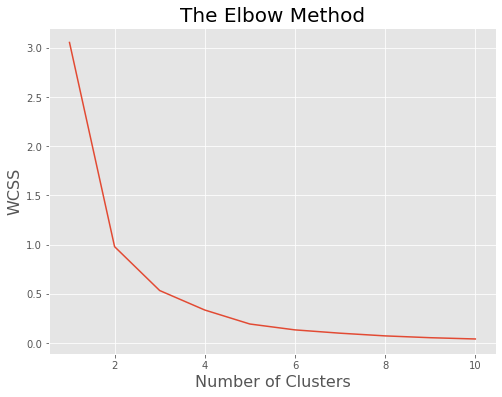

In [81]:
#Transformation process: normalizing our values
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler((0,1))
x_scaled = min_max_scaler.fit_transform(tx_user[['Revenue']])
data_scaled = pd.DataFrame(x_scaled)


plt.figure(figsize=(8,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=10, max_iter = 300)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('Number of Clusters',fontsize=16)
plt.ylabel('WCSS',fontsize=16)
plt.show()

In [82]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [83]:
tx_user.count()

Customer ID         4268
Recency             4268
RecencyCluster      4268
Frequency           4268
FrequencyCluster    4268
Revenue             4268
RevenueCluster      4268
dtype: int64

### <u> Overall scoring </u>

In [84]:
#overall scoring
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>3,'Segment'] = 'High-Value'

In [85]:
tx_user.count()

Customer ID         4268
Recency             4268
RecencyCluster      4268
Frequency           4268
FrequencyCluster    4268
Revenue             4268
RevenueCluster      4268
OverallScore        4268
Segment             4268
dtype: int64

In [86]:
tx_user.head(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0   2017.2   
1      12636.0      364               0          1                 0    141.0   
2      12362.0      364               0          1                 0    130.0   
3      16321.0      252               0         11                 0    230.9   
4      17592.0      364               0         13                 0    148.3   

   RevenueCluster  OverallScore    Segment  
0               0             0  Low-Value  
1               0             0  Low-Value  
2               0             0  Low-Value  
3               0             0  Low-Value  
4               0             0  Low-Value

### <u> Calulating revenue by multiplying price and quantity </u>

In [87]:
#calculate revenue and create a new dataframe for it
tx_6m['Revenue'] = tx_6m['Price'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('Customer ID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['Customer ID','m6_Revenue']


In [88]:
tx_user_6m

Customer ID  m6_Revenue
0         12346.0    77183.60
1         12347.0     4085.18
2         12348.0     1797.24
3         12349.0     1757.55
4         12350.0      334.40
...           ...         ...
4293      18280.0      180.60
4294      18281.0       80.82
4295      18282.0      100.21
4296      18283.0     1837.53
4297      18287.0     1837.28

[4298 rows x 2 columns]

In [89]:
tx_user.count()


Customer ID         4268
Recency             4268
RecencyCluster      4268
Frequency           4268
FrequencyCluster    4268
Revenue             4268
RevenueCluster      4268
OverallScore        4268
Segment             4268
dtype: int64

In [90]:
tx_user_6m.count()

Customer ID    4298
m6_Revenue     4298
dtype: int64

### <u> Merging together

In [91]:

tx_merge = pd.merge(tx_user, tx_user_6m, on='Customer ID', how='left')

tx_graph = tx_merge.query("m6_Revenue < 30000")

In [92]:
tx_merge.tail(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
4263      18102.0       15               2        609                 2   
4264      14646.0        0               2       1774                 3   
4265      13694.0        6               2        951                 2   
4266      14156.0        4               2       2643                 3   
4267      14911.0        1               2       5407                 4   

        Revenue  RevenueCluster  OverallScore     Segment  m6_Revenue  
4263  321329.74               4             8  High-Value   248171.76  
4264  248396.50               4             9  High-Value   268478.00  
4265  130601.07               3             7  High-Value    61908.46  
4266  196227.54               3             8  High-Value   117210.08  
4267  147709.64               3             9  High-Value   136732.25

### <u>Removing Outliers</u>

In [93]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]


#creating 2 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

count         mean          std      min       25%       50%  \
LTVCluster                                                                  
0           2502.0  1190.995845  1170.462087     6.90   326.280   722.575   
1            183.0  9435.320328  4330.872886  5357.71  6250.695  7792.360   

                  75%       max  
LTVCluster                       
0            1681.275   5291.33  
1           11050.340  26708.42

In [94]:
tx_merge.count()

Customer ID         2685
Recency             2685
RecencyCluster      2685
Frequency           2685
FrequencyCluster    2685
Revenue             2685
RevenueCluster      2685
OverallScore        2685
Segment             2685
m6_Revenue          2685
LTVCluster          2685
dtype: int64

### <u>Convert categorical columns to numerical </u>

In [95]:
tx_class = pd.get_dummies(tx_cluster)

### <u>Correlations calculation </u>

In [96]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.793018
Revenue               0.505408
RevenueCluster        0.497062
Segment_High-Value    0.409387
OverallScore          0.362241
FrequencyCluster      0.314966
Frequency             0.304176
RecencyCluster        0.114772
Customer ID          -0.075173
Recency              -0.143679
Segment_Low-Value    -0.409387
Name: LTVCluster, dtype: float64

                                       Correlation Matrix                                       


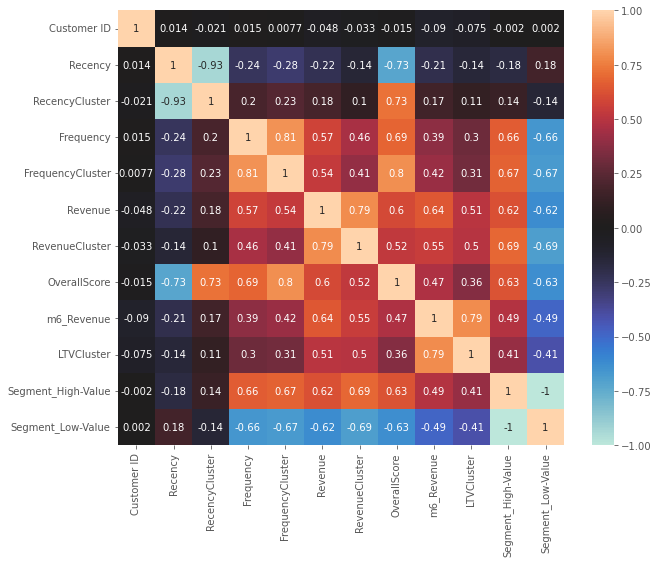

In [97]:
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[10,8])
sns.heatmap(tx_class.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [98]:
df_sample_data=tx_class

In [99]:
tx_class

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0         13085.0      305               0         62                 0   
1         12362.0      364               0          1                 0   
2         16321.0      252               0         11                 0   
3         15326.0      235               0        100                 0   
4         16763.0      364               0         21                 0   
...           ...      ...             ...        ...               ...   
2680      14527.0        0               2       1668                 3   
2681      15039.0        1               2       1218                 3   
2682      14606.0        1               2       3682                 4   
2683      13093.0        0               2        878                 2   
2684      17850.0       64               2       2202                 3   

       Revenue  RevenueCluster  OverallScore  m6_Revenue  LTVCluster  \
0      2017.20               0             0      416.08           0   
1       130.00               0             0     4697.19           0   
2       230.90               0             0      373.65           0   
3      1388.81               0             0      311.71           0   
4       352.85               0             0      611.85           0   
...        ...             ...           ...         ...         ...   
2680  18739.75               1             6     7875.18           1   
2681  19374.89               1             6    19766.59           1   
2682  17875.22               1             7    11734.31           1   
2683  46311.78               2             6     7832.47           1   
2684  45817.66               2             7     5391.21           1   

      Segment_High-Value  Segment_Low-Value  
0                      0                  1  
1                      0                  1  
2                      0                  1  
3                      0                  1  
4                      0                  1  
...                  ...                ...  
2680                   1                  0  
2681                   1                  0  
2682                   1                  0  
2683                   1                  0  
2684                   1                  0  

[2685 rows x 12 columns]

## Algorithms and Techniques
This problem has a vast list of viable solutions. There are a lot of ways to approach this problem, but we'll use data size, computational efficiency, and cross-validation scores on the training set to cut down the choice of techniques. The prerequisites of our setup must be considered in order to get closer to a conclusion on the probable method. A data collection with more than 10 data points is necessary to use any machine learning algorithm.That criterion is met in this circumstance. Because the data is labeled, this study falls under the category of supervised learning. However, due of the domain's complexity, the research intends to create an additional variable using unsupervised learning. As a result, an additional discrete variable is produced, which assigns customers to a specific cluster based on their attributes. The concept behind many supervised and unsupervised classification methods is discussed in this section.

### Supervised Algorithms
The first section examines supervised learning algorithms, highlighting some of its benefits and limitations. While some models are better suited for huge datasets, others are better suited for small datasets. 1,000,000 data points is a prefered thershold for machine learning systems. The task of learning a function that maps an input to an output based on examples of input-output pairs using machine learning.

#### Support Vector Machine
Support Vector Machines (SVMs) are supervised learning algorithms that use statistical learning theory to execute the concepts. To account for a higher level of data complexity, these will be used in both linear and non-linear implementations. SVMs are less prone to overfit since they have a high accuracy while keeping a low variance. This model performs exceptionally well in complex domains with distinct margin separation. To identify the data points from one another, SVM creates a hyper-plane. The assumption is that the bigger the margin between each class's nearest data points, the better the separation criteria. Even if the data isn't linearly separable, this model usually performs admirably. The model, on the other hand, performs poorly or extremely slowly if the data contains a lot of noise or the amount is too huge. Given that the data base in a running environment tends to grow, this strategy may become unfeasible if used in a live system. The penalty parameter C of the error term, the employed loss-function, and the quantity of maximum iterations to run, as well as the l2 penalty function, will all be tried in order to acquire the best result for linear SVM. For greater complexity, the implementation with a more complicated kernel will take into account a variety of various kernel functions as well as a variety of polynomial degrees.

#### Logistic Regression
One of the most fundamental linear models for classification is logistic regression (LR). It's best for predicting dependent variables that are either binary or discrete. For machine-learning challenges, LR is usually a quick and simple answer. Its implementation is similar to SVM, however it has the advantage of working better on huge data sets. There are a variety of approaches to regularize the model, and feature correlation isn't as important. Another of its major benefits is that fresh data can be quickly added and the model may be changed in real time.Its adaptability makes it ideal for a running system that needs to be tweaked over time to improve the model or injected with more data. One disadvantage of LR is that it may struggle with binary features. This could be a problem in this data collection, which has a large number of category attributes. The penalty parameter C of the error term is also used in Logistic Regression tuning. Furthermore, many solvers are employed, as well as a variation on whether the algorithm can reuse the solution from the previous call as initialization or if it must erase the prior solution.

#### Decision Tree Classifier
A Decision Tree model is another viable alternative (DT). Decision trees are simple to understand and interpret. They're also pretty resistant to outliers, and pruning helps prevent them from overfitting. Decision Trees, on the other hand, do not support online learning and must be rebuilt every time new information is received. This might be significant if the data used is updated on a regular basis rather than just once every quarter. Decision Trees may be at a disadvantage if an accurate turnover prediction model is required that runs all year on current data and updated models. The function for calculating the splitting criterion measure, the amount of features to examine while looking for the best split, and the maximum depth a tree can have are all Decision Tree factors that are taken into account.

#### Random Forest
Random Forest is an example of an ensemble method that incorporates trees (RF). The ability of RF to accept non-linear features could be a selling point. It can handle category features extremely well, other from LR. It's also well suited for huge numbers of training examples and high-dimensional spaces in case extra characteristics are added or engineered. As previously said, this can be useful for future applications as the data base grows. However, one of the fundamental drawbacks of RF-models is their lack of sensitivity to correlated characteristics. Strong traits may receive low ratings when using associated features. Different criteria for measuring splitting performance, the ability to bootstrap samples or not, several functions to calculate the maximum features per tree, a maximum depth of the tree, an array of minimum splits per sample, and several options for the maximum number of leaf nodes a tree can have are all parameters that will be tweaked to find the best working solution. In addition, the performance of this algorithm will be evaluated with and without the ability to perform a warm start.


### Unsupervised Algorithms
The mixing of discrete and continuous variables is a challenge in this research when it comes to unsupervised algorithms. When working with categorical data, most of the techniques presented here are better suited for continuous variables and may perform less accurately. As a result, this section is designed to be used in conjunction with supervised learning models. 

#### Gaussian Mixture Model
GMMs are probabilistic models for describing normally distributed subpopulations within a larger population. When the underlying populations can be described by a normal distribution and there are numerous diverse populations available, GMMs are frequently utilized. As an example based on this [post](https://www.quora.com/What-is-an-example-of-real-world-application-of-Gaussian-Mixture-Models/answer/Hongsun-Kim), we may look at the average evaluation scores for employees in several areas, such as R&D, accounting, human resources, management, marketing, product management, sales, support, and technical. It's safe to presume that each department's assessment score distribution is slightly different and follows a normal distribution. The percentage of the population that comes from each department, as indicated above, might be used as a weighting element. This is a Guassian Mixture Model with 9 points. GMM's main advantages include density estimations for each cluster, some freedom in selecting the component distribution, and the ability to perform soft categorization. GMM is a Bayesian clustering method. Soft clustering is introduced, which means that data points might belong to more than one cluster.The program also determines the likelihood that a data point belongs to a specific center. It's also noted for accurately reflecting real-world circumstances.

#### K-Means Clustering
K-Means may be thought of as a specific instance of GMM in which the covariance of each cluster along all dimensions approaches zero. In other words, each data point will be given to a single cluster. K-Means is strong and simple to grasp, which are two of its main advantages. When data points are different or groups within groups are well isolated from one other, it is computationally efficient and produces excellent results.

We'll utilize a GMM implementation because we're working with a real-world scenario and a data collection where distinguishing between data points might be difficult at times. This also gives us the option of soft-labeling our data points and fine-tuning the grouping afterwards.



## <center><u> TRAINING AND TESTING MODELS </U></CENTER>

In [100]:
#create X and y, X will be feature set and y is the label - LTV
X_all_base = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y_all_base = tx_class['LTVCluster']

### <U> Creating train and test splits from the data </u>

In [101]:
# Let's keep 20 % of the data for testing purposes
test_size = .20
random_state = 45
# Use for testing later and don't touch: X_test_base / y_test_base
X_train_base, X_test_base, y_train_base, y_test_base = cross_validation.train_test_split(
    X_all_base, y_all_base, test_size = test_size, random_state = random_state)
clf_dict_base = {}
clf_report_base = []
clf_feature_relevance_base = []

### <u> Using training data </u>

In [102]:
clf_dict_base = {}
clf_report_base = []
clf_feature_relevance_base = []
for clf in [LinearSVC(random_state = random_state),
            LogisticRegression(random_state = random_state),
            DecisionTreeClassifier(random_state = random_state),
            SVC(random_state = random_state),
            RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf.__class__.__name__
    print ("Training", clf_name, "...")
    # Fit model on training data
    clf_dict_base[clf_name] = clf.fit(X_train_base, y_train_base)
    # Predict based on it
    # y_pred = clf.predict(X_train)
    
    # Perform cross validation
    start = time()
    X_s, y_s = shuffle(X_train_base, y_train_base)
    scores = cross_validation.cross_val_score(clf, X_s, y_s, cv=5, scoring='accuracy')
    end = time()
    duration = end - start
    print ("Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration))
    clf_report_base.append([clf_name, scores.mean(), duration])

    # Sample Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance_base.append(clf.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance_base.append(clf.coef_[0].tolist())
# Store information in list for better visibility
clf_report_base = pd.DataFrame(clf_report_base, columns=['classifier', 'Train_accuracy', 'Train_time'])

Training LinearSVC ...
Average CV performance for LinearSVC: 0.942274 (in 0.382776 seconds)
Training LogisticRegression ...
Average CV performance for LogisticRegression: 0.942271 (in 0.160131 seconds)
Training DecisionTreeClassifier ...
Average CV performance for DecisionTreeClassifier: 0.918997 (in 0.0823781 seconds)
Training SVC ...
Average CV performance for SVC: 0.939938 (in 0.317327 seconds)
Training RandomForestClassifier ...
Average CV performance for RandomForestClassifier: 0.936689 (in 1.44104 seconds)


In [103]:
pd.DataFrame(clf_feature_relevance_base, columns=X_train_base.columns, index=['LinearSVC', 
                                                                              'DecisionTreeClassifier', 
                                                                              'RandomForestClassifier'])

Customer ID   Recency  RecencyCluster  Frequency  \
LinearSVC                 -0.000079 -0.000937       -0.000083  -0.000355   
DecisionTreeClassifier     0.150018  0.108136        0.008684   0.135979   
RandomForestClassifier     0.172689  0.119821        0.005341   0.162236   

                        FrequencyCluster   Revenue  RevenueCluster  \
LinearSVC                       0.000031  0.000147        0.000024   
DecisionTreeClassifier          0.008826  0.566381        0.000000   
RandomForestClassifier          0.015250  0.385703        0.059820   

                        OverallScore  Segment_High-Value  Segment_Low-Value  
LinearSVC                  -0.000028            0.000045          -0.000083  
DecisionTreeClassifier      0.013292            0.000000           0.008684  
RandomForestClassifier      0.043215            0.020406           0.015519

### <u> Accuracy and time taken by different models</u>

In [104]:
clf_report_base.sort_values(by=['Train_accuracy', 'Train_time'], ascending=False)

classifier  Train_accuracy  Train_time
0               LinearSVC        0.942274    0.382776
1      LogisticRegression        0.942271    0.160131
3                     SVC        0.939938    0.317327
4  RandomForestClassifier        0.936689    1.441045
2  DecisionTreeClassifier        0.918997    0.082378

In [105]:
tx_class.head(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0  2017.20   
1      12362.0      364               0          1                 0   130.00   
2      16321.0      252               0         11                 0   230.90   
3      15326.0      235               0        100                 0  1388.81   
4      16763.0      364               0         21                 0   352.85   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             0      416.08           0                   0   
1               0             0     4697.19           0                   0   
2               0             0      373.65           0                   0   
3               0             0      311.71           0                   0   
4               0             0      611.85           0                   0   

   Segment_Low-Value  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [106]:
predictor_list_base = []
for relevance in clf_dict_base['RandomForestClassifier'].feature_importances_:
    predictor_list_base.append(relevance)
new_base = pd.DataFrame(predictor_list_base, columns=['importance'], index=X_all_base.columns.values.tolist())
new_base.sort_values(by='importance', ascending=False, inplace=True)
new_base['features'] = new_base.index



### <u> Using the Testing data </u>`

In [107]:
clf_dict_base_test = {}
clf_report_base_test = []
clf_feature_relevance_base_test = []

for clf in [LinearSVC(random_state = random_state),
            LogisticRegression(random_state = random_state),
            DecisionTreeClassifier(random_state = random_state),
            SVC(random_state = random_state),
            RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf.__class__.__name__
    print ("Testing", clf_name, "...")
    # Fit model on training data
    clf_dict_base[clf_name] = clf.fit(X_train_base, y_train_base)
    # Predict based on it
    # y_pred = clf.predict(X_train)
    
    # Perform cross validation
    start = time()
    X_t, y_t = shuffle(X_test_base, y_test_base)
    scores = cross_validation.cross_val_score(clf, X_t, y_t, cv=5, scoring='accuracy')
    end = time()
    duration = end - start
    print ("Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration))
    clf_report_base_test.append([clf_name, scores.mean(), duration])

    # Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance_base_test.append(clf.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance_base_test.append(clf.coef_[0].tolist())
# Store information in list for better visibility

clf_report_base_test = pd.DataFrame(clf_report_base_test, columns=['classifier', 'Test_accuracy', 'Test_time'])

Testing LinearSVC ...
Average CV performance for LinearSVC: 0.936691 (in 0.0810332 seconds)
Testing LogisticRegression ...
Average CV performance for LogisticRegression: 0.942264 (in 0.0902932 seconds)
Testing DecisionTreeClassifier ...
Average CV performance for DecisionTreeClassifier: 0.927362 (in 0.0306773 seconds)
Testing SVC ...
Average CV performance for SVC: 0.931118 (in 0.052263 seconds)
Testing RandomForestClassifier ...
Average CV performance for RandomForestClassifier: 0.932883 (in 0.889906 seconds)


### <u> Accuracy and time taken by different models</u>

In [108]:
clf_report_base_test.sort_values(by=['Test_accuracy', 'Test_time'], ascending=False)

classifier  Test_accuracy  Test_time
1      LogisticRegression       0.942264   0.090293
0               LinearSVC       0.936691   0.081033
4  RandomForestClassifier       0.932883   0.889906
3                     SVC       0.931118   0.052263
2  DecisionTreeClassifier       0.927362   0.030677

The Random Forest and SVC ensemble model has the best average cross validation score.<br>
Finetuning of the algorithm parameters will happen later, once the unsupervised additions have been computed.

### <u> Principal Component Analysis </u>

In [109]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA as RandomizedPCA

def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (25,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [110]:
tx_class.head(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0  2017.20   
1      12362.0      364               0          1                 0   130.00   
2      16321.0      252               0         11                 0   230.90   
3      15326.0      235               0        100                 0  1388.81   
4      16763.0      364               0         21                 0   352.85   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             0      416.08           0                   0   
1               0             0     4697.19           0                   0   
2               0             0      373.65           0                   0   
3               0             0      311.71           0                   0   
4               0             0      611.85           0                   0   

   Segment_Low-Value  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

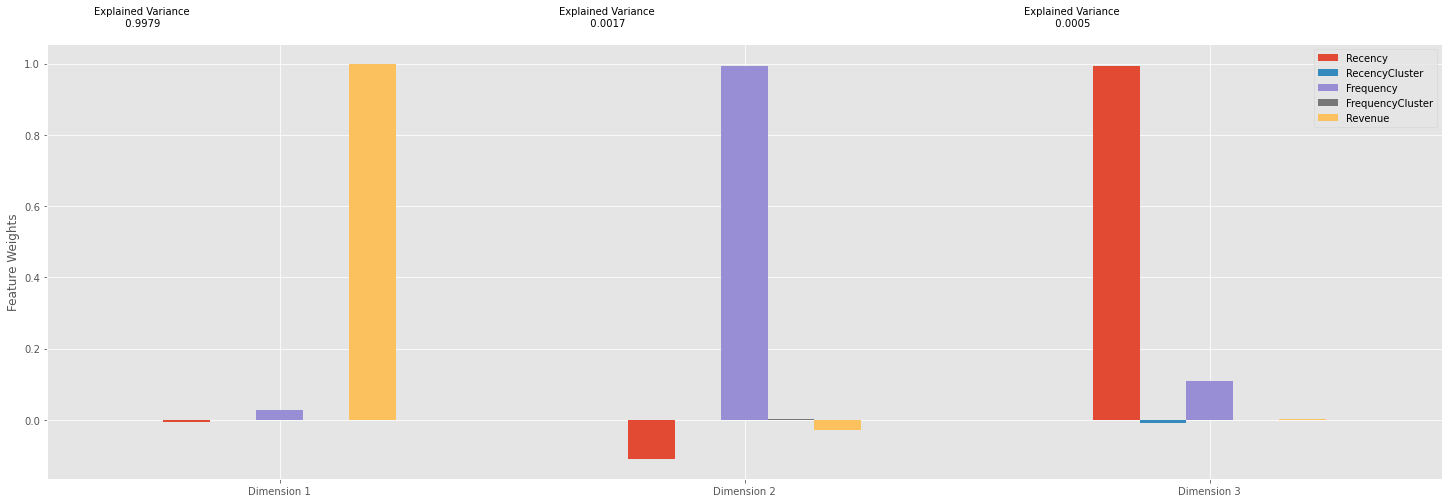

In [111]:
from sklearn.decomposition import PCA 

pca_data = df_sample_data.iloc[:,1:6]
pca = PCA(n_components=3)
pca = pca.fit(pca_data)

# Generate PCA results plot
pca_results = pca_results(pca_data, pca)

In [112]:
pd.DataFrame(data=[np.cumsum(pca.explained_variance_ratio_)], columns="Add " + 
             pca_results.index.values, index=['Combined Explained Variance'])

Add Dimension 1  Add Dimension 2  Add Dimension 3
Combined Explained Variance          0.99786         0.999532              1.0

In [113]:
tx_class.head(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0  2017.20   
1      12362.0      364               0          1                 0   130.00   
2      16321.0      252               0         11                 0   230.90   
3      15326.0      235               0        100                 0  1388.81   
4      16763.0      364               0         21                 0   352.85   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             0      416.08           0                   0   
1               0             0     4697.19           0                   0   
2               0             0      373.65           0                   0   
3               0             0      311.71           0                   0   
4               0             0      611.85           0                   0   

   Segment_Low-Value  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [114]:
df_sample_data.head(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0  2017.20   
1      12362.0      364               0          1                 0   130.00   
2      16321.0      252               0         11                 0   230.90   
3      15326.0      235               0        100                 0  1388.81   
4      16763.0      364               0         21                 0   352.85   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             0      416.08           0                   0   
1               0             0     4697.19           0                   0   
2               0             0      373.65           0                   0   
3               0             0      311.71           0                   0   
4               0             0      611.85           0                   0   

   Segment_Low-Value  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [115]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca = pca.fit(pca_data)

reduced_data = pca.transform(pca_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])

In [116]:
tx_class.head(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0  2017.20   
1      12362.0      364               0          1                 0   130.00   
2      16321.0      252               0         11                 0   230.90   
3      15326.0      235               0        100                 0  1388.81   
4      16763.0      364               0         21                 0   352.85   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             0      416.08           0                   0   
1               0             0     4697.19           0                   0   
2               0             0      373.65           0                   0   
3               0             0      311.71           0                   0   
4               0             0      611.85           0                   0   

   Segment_Low-Value  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

### <u>Calculating Sillhoutte Score </u>

In [117]:
from sklearn import mixture
from sklearn.metrics import silhouette_score

score_list = []
score_columns = []
preds = {}
centers = {}
sample_preds = {}

for n in range(4,1,-1):
    print ("Calculating clusters with {} dimensions.".format(n))
    clusterer = mixture.GaussianMixture(n_components=n)
    # Future
    # clusterer = mixture.GaussianMixture(n_components=n)
    clusterer.fit(reduced_data)

    preds[n] = clusterer.predict(reduced_data)
    centers[n] = clusterer.means_
    score = silhouette_score(reduced_data, preds[n], metric='euclidean')
    score_list.append(score)
    score_columns.append(str(n) + " components")

score_list = pd.DataFrame(data=[score_list],columns=score_columns, index=['Silhouette Score'])
score_list

Calculating clusters with 4 dimensions.
Calculating clusters with 3 dimensions.
Calculating clusters with 2 dimensions.


4 components  3 components  2 components
Silhouette Score      0.355523      0.357864      0.541182

In [118]:
tx_class.head(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0  2017.20   
1      12362.0      364               0          1                 0   130.00   
2      16321.0      252               0         11                 0   230.90   
3      15326.0      235               0        100                 0  1388.81   
4      16763.0      364               0         21                 0   352.85   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             0      416.08           0                   0   
1               0             0     4697.19           0                   0   
2               0             0      373.65           0                   0   
3               0             0      311.71           0                   0   
4               0             0      611.85           0                   0   

   Segment_Low-Value  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [119]:
def cluster_results(reduced_data, preds, centers):
    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (10,5))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    # Set plot title
    #plt.legend(loc='upper left', numpoints=1, ncol=4, fontsize=12, bbox_to_anchor=(0, 0))
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number",
                 fontsize = 14)

In [120]:
def cluster_results_3d(reduced_data, preds, centers):
    from mpl_toolkits.mplot3d import Axes3D
    
    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)
    cmap = cm.get_cmap('gist_rainbow')
    
    fig = plt.figure(figsize = (20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax2 = fig.add_subplot(111, projection='3d')

    fig = fig.gca(projection='3d')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c[2], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200,
                   zorder=1);
        ax2.scatter(c[0], c[1], c[2], marker='$%d$'%(i), alpha = 1, s=100,
                   zorder=1);
        
    for i, cluster in plot_data.groupby('Cluster'):   
        ax2.scatter(cluster['Dimension 1'], cluster['Dimension 2'], cluster['Dimension 3'],
                   c = cmap((i)*1.0/(len(centers)-1)), alpha=0.2,
                   label = 'Cluster %i'%(i), s=20,
                   zorder=.5)

    fig.set_xlabel('Dimension 1')
    fig.set_ylabel('Dimension 2')
    fig.set_zlabel('Dimension 3')
    plt.legend(loc='upper left', numpoints=1, ncol=4, fontsize=12, bbox_to_anchor=(0, 0))
    ax2.set_title("Cluster Learning on PCA-Reduced Data 3D Plot",
                 fontsize = 14);
    plt.show()

### <u> Visualizing cluster results </u>

In [121]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

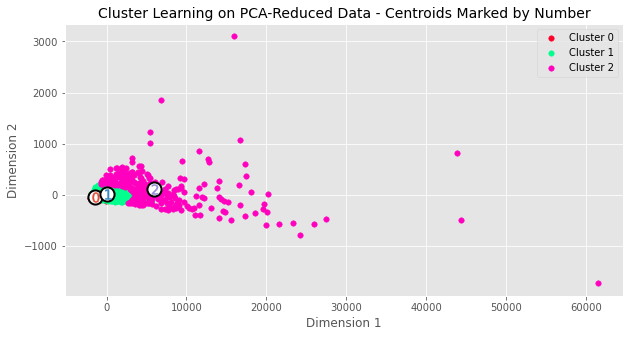

In [122]:
# with preds[n] and centers[n] where n is the number of Dimensions
no_clusters = 3
cluster_results(reduced_data, preds[no_clusters], centers[no_clusters])


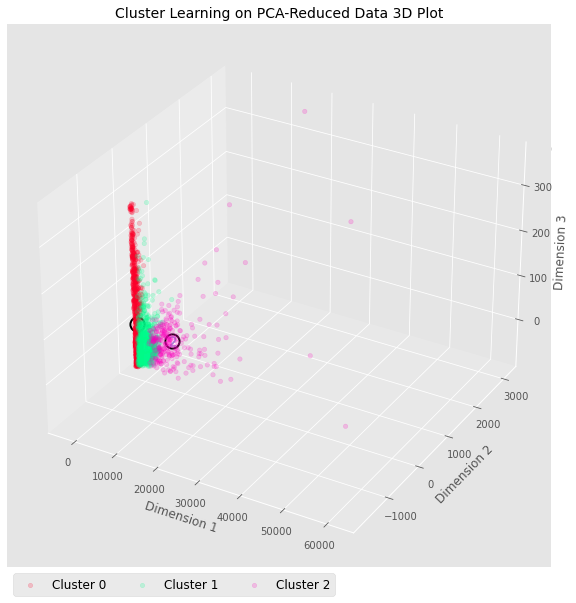

In [123]:
cluster_results_3d(reduced_data, preds[no_clusters], centers[no_clusters])

In [124]:
predictions = pd.DataFrame(preds[no_clusters], columns = ['Cluster'])
df_sample_data['customer_cluster'] = predictions

In [125]:
df_sample_data.head()

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0  2017.20   
1      12362.0      364               0          1                 0   130.00   
2      16321.0      252               0         11                 0   230.90   
3      15326.0      235               0        100                 0  1388.81   
4      16763.0      364               0         21                 0   352.85   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             0      416.08           0                   0   
1               0             0     4697.19           0                   0   
2               0             0      373.65           0                   0   
3               0             0      311.71           0                   0   
4               0             0      611.85           0                   0   

   Segment_Low-Value  customer_cluster  
0                  1                 0  
1                  1                 0  
2                  1                 0  
3                  1                 0  
4                  1                 0

In [126]:
print (df_sample_data.columns)

Index(['Customer ID', 'Recency', 'RecencyCluster', 'Frequency',
       'FrequencyCluster', 'Revenue', 'RevenueCluster', 'OverallScore',
       'm6_Revenue', 'LTVCluster', 'Segment_High-Value', 'Segment_Low-Value',
       'customer_cluster'],
      dtype='object')


In [127]:
df_sample_data.head(5)

Customer ID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0      13085.0      305               0         62                 0  2017.20   
1      12362.0      364               0          1                 0   130.00   
2      16321.0      252               0         11                 0   230.90   
3      15326.0      235               0        100                 0  1388.81   
4      16763.0      364               0         21                 0   352.85   

   RevenueCluster  OverallScore  m6_Revenue  LTVCluster  Segment_High-Value  \
0               0             0      416.08           0                   0   
1               0             0     4697.19           0                   0   
2               0             0      373.65           0                   0   
3               0             0      311.71           0                   0   
4               0             0      611.85           0                   0   

   Segment_Low-Value  customer_cluster  
0                  1                 0  
1                  1                 0  
2                  1                 0  
3                  1                 0  
4                  1                 0

## <center><u> TRAINING AND TESTING MODELS - AFTER CLUSTERING USING GMM</U></CENTER>

### <U>Using Training Data</u>

In [128]:
# Let's start the prediction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection
from time import time
# Let's keep 20 % of the data for testing purposes
test_size = .20
random_state = 45
#create X and y, X will be feature set and y is the label - LTV
X_all_clus = df_sample_data.drop(['LTVCluster','m6_Revenue'],axis=1)
y_all_clus = df_sample_data['LTVCluster']
# Use for testing later and don't touch: X_test_clus / y_test_clus
X_train_clus, X_test_clus, y_train_clus, y_test_clus = cross_validation.train_test_split(
    X_all_clus, y_all_clus, test_size = test_size, random_state = random_state, stratify=y_all_clus)
clf_dict_clus = {}
clf_report_clus = []
clf_feature_relevance_clus = []
for clf_clus in [LinearSVC(random_state = random_state),
                LogisticRegression(random_state = random_state),
                DecisionTreeClassifier(random_state = random_state),
                SVC(random_state = random_state),
                RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf_clus.__class__.__name__
    print ("Training", clf_name, "...")
    # Fit model on training data
    clf_dict_clus[clf_name] = clf_clus.fit(X_train_clus, y_train_clus)
    # Predict based on it
    # y_pred = clf.predict(X_train)    
    # Perform cross validation
    start = time()
    scores = cross_validation.cross_val_score(clf_clus, X_train_clus, y_train_clus, cv=5, scoring='accuracy') 
    end = time()
    duration = end - start
    print ("Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration))
    clf_report_clus.append([clf_name, scores.mean(), duration])
    # Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance_clus.append(clf_clus.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance_clus.append(clf_clus.coef_[0].tolist())
# Store information in list for better visibility
clf_report_clus = pd.DataFrame(clf_report_clus, columns=['classifier', 'Cluster_train_accuracy', 'Cluster_train_time'])

Training LinearSVC ...
Average CV performance for LinearSVC: 0.941801 (in 0.648868 seconds)
Training LogisticRegression ...
Average CV performance for LogisticRegression: 0.943662 (in 0.199894 seconds)
Training DecisionTreeClassifier ...
Average CV performance for DecisionTreeClassifier: 0.909674 (in 0.0901754 seconds)
Training SVC ...
Average CV performance for SVC: 0.939939 (in 0.286194 seconds)
Training RandomForestClassifier ...
Average CV performance for RandomForestClassifier: 0.940872 (in 1.62078 seconds)


In [129]:
pd.DataFrame(clf_feature_relevance_clus, columns=X_train_clus.columns, index=['LinearSVC', 
                                                                              'DecisionTreeClassifier', 
                                                                              'RandomForestClassifier'])

Customer ID   Recency  RecencyCluster  Frequency  \
LinearSVC                 -0.000075 -0.000937       -0.000066  -0.000155   
DecisionTreeClassifier     0.191148  0.125629        0.005761   0.172614   
RandomForestClassifier     0.179341  0.120300        0.004162   0.157337   

                        FrequencyCluster   Revenue  RevenueCluster  \
LinearSVC                       0.000014  0.000097        0.000026   
DecisionTreeClassifier          0.000000  0.498725        0.000000   
RandomForestClassifier          0.017586  0.312060        0.074400   

                        OverallScore  Segment_High-Value  Segment_Low-Value  \
LinearSVC                  -0.000026            0.000023          -0.000055   
DecisionTreeClassifier      0.006124            0.000000           0.000000   
RandomForestClassifier      0.029567            0.018611           0.025829   

                        customer_cluster  
LinearSVC                       0.000083  
DecisionTreeClassifier          0.000000  
RandomForestClassifier          0.060807

### <u> Accuracy and time taken by different models</u>

In [130]:
clf_report_clus = clf_report_clus.iloc[:,0:3]
clf_report_clus.sort_values('Cluster_train_accuracy', ascending=False)

classifier  Cluster_train_accuracy  Cluster_train_time
1      LogisticRegression                0.943662            0.199894
0               LinearSVC                0.941801            0.648868
4  RandomForestClassifier                0.940872            1.620781
3                     SVC                0.939939            0.286194
2  DecisionTreeClassifier                0.909674            0.090175

### <u>Using Testing Data</u>

In [131]:
# Let's start the prediction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection
from time import time

# Let's keep 20 % of the data for testing purposes
test_size = .35
random_state = 42

#create X and y, X will be feature set and y is the label - LTV
X_all_clus = df_sample_data.drop(['LTVCluster','m6_Revenue'],axis=1)
y_all_clus = df_sample_data['LTVCluster']

# Use for testing later and don't touch: X_test_clus / y_test_clus
X_train_clus, X_test_clus, y_train_clus, y_test_clus = cross_validation.train_test_split(
    X_all_clus, y_all_clus, test_size = test_size, random_state = random_state, stratify=y_all_clus)

clf_dict_clus_test = {}
clf_report_clus_test = []
clf_feature_relevance_clus_test = []

for clf_clus in [LinearSVC(random_state = random_state),
                LogisticRegression(random_state = random_state),
                DecisionTreeClassifier(random_state = random_state),
                SVC(random_state = random_state),
                RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf_clus.__class__.__name__
    print ("Testing", clf_name, "...")
    # Fit model on training data
    clf_dict_clus[clf_name] = clf_clus.fit(X_train_clus, y_train_clus)
    # Predict based on it
    # y_pred = clf.predict(X_train)
    
    # Perform cross validation
    start = time()
    scores = cross_validation.cross_val_score(clf_clus, X_test_clus, y_test_clus, cv=5, scoring='accuracy') 
    end = time()
    duration = end - start
    print ("Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration))
    clf_report_clus_test.append([clf_name, scores.mean(), duration])

    # Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance_clus_test.append(clf_clus.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance_clus_test.append(clf_clus.coef_[0].tolist())
# Store information in list for better visibility

clf_report_clus_test = pd.DataFrame(clf_report_clus_test, columns=['classifier', 'Cluster_test_accuracy', 'Cluster_test_time'])

Testing LinearSVC ...
Average CV performance for LinearSVC: 0.937234 (in 0.158515 seconds)
Testing LogisticRegression ...
Average CV performance for LogisticRegression: 0.944681 (in 0.142508 seconds)
Testing DecisionTreeClassifier ...
Average CV performance for DecisionTreeClassifier: 0.912766 (in 0.0506003 seconds)
Testing SVC ...
Average CV performance for SVC: 0.939362 (in 0.108728 seconds)
Testing RandomForestClassifier ...
Average CV performance for RandomForestClassifier: 0.945745 (in 1.01862 seconds)


### <u> Accuracy and time taken by different models</u>

In [132]:
clf_report_clus_test = clf_report_clus_test.iloc[:,0:3]
clf_report_clus_test.sort_values('Cluster_test_accuracy', ascending=False)

classifier  Cluster_test_accuracy  Cluster_test_time
4  RandomForestClassifier               0.945745           1.018619
1      LogisticRegression               0.944681           0.142508
3                     SVC               0.939362           0.108728
0               LinearSVC               0.937234           0.158515
2  DecisionTreeClassifier               0.912766           0.050600

## <center> <u> VISUALIZATION </center></u>

### <u>Feature importance without cluster information </u>

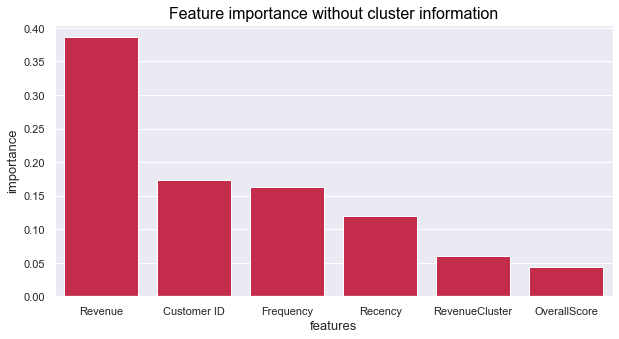

In [133]:
predictor_list = []
for relevance in clf_dict_base['RandomForestClassifier'].feature_importances_:
    predictor_list.append(relevance)


columns_list = X_all_base.columns.values.tolist()

new = pd.DataFrame(predictor_list, columns=['importance'], index=columns_list)
new.sort_values(by='importance', ascending=False, inplace=True)
new['features'] = new.index
new = new[:6]


new

sns.set(rc = {'figure.figsize':(10,5)})
#sns.set_style('whitegrid')
sns.set(font_scale=1)
plt.title('Feature importance without cluster information', size=16,color='BLACK')
plt.xlabel('features', size=13)
plt.ylabel('importance', size=13)
g = sns.barplot(data=new,x = 'features', y = 'importance', color='crimson')

### <u>Feature importance with cluster information </u>

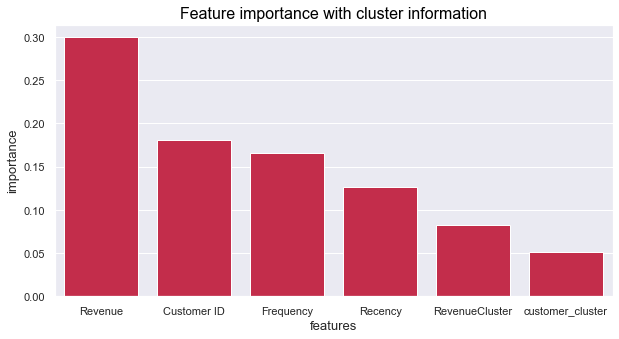

In [134]:

predictor_list_clus = []
for relevance in clf_dict_clus['RandomForestClassifier'].feature_importances_:
    predictor_list_clus.append(relevance)
new_clus = pd.DataFrame(predictor_list_clus, columns=['importance'], index=X_all_clus.columns.values.tolist())
new_clus.sort_values(by='importance', ascending=False, inplace=True)
new_clus['features'] = new_clus.index

new_clus = new_clus[:6]

sns.set(rc = {'figure.figsize':(10,5)})
#sns.set_style('whitegrid')
sns.set(font_scale=1)
plt.title('Feature importance with cluster information', size=16,color='BLACK')
plt.xlabel('features', size=13)
plt.ylabel('importance', size=13)
g = sns.barplot(data=new_clus,x = 'features', y = 'importance', color='crimson')



In [135]:
clf_report_base

classifier  Train_accuracy  Train_time
0               LinearSVC        0.942274    0.382776
1      LogisticRegression        0.942271    0.160131
2  DecisionTreeClassifier        0.918997    0.082378
3                     SVC        0.939938    0.317327
4  RandomForestClassifier        0.936689    1.441045

## <center><u> FINAL RESULTS </center></u>

In [136]:
final_result=pd.DataFrame()
final_result['classifier']=clf_report_base['classifier']
final_result['Train_accuracy']=clf_report_base['Train_accuracy']
final_result['Train_time']=clf_report_base['Train_time']
final_result['Test_accuracy']=clf_report_base_test['Test_accuracy']
final_result['Test_time']=clf_report_base_test['Test_time']
final_result['Cluster_train_accuracy']=clf_report_clus['Cluster_train_accuracy']
final_result['Cluster_train_time']=clf_report_clus['Cluster_train_time']
final_result['Cluster_test_accuracy']=clf_report_clus_test['Cluster_test_accuracy']
final_result['Cluster_test_time']=clf_report_clus_test['Cluster_test_time']

In [137]:
final_result

classifier  Train_accuracy  Train_time  Test_accuracy  \
0               LinearSVC        0.942274    0.382776       0.936691   
1      LogisticRegression        0.942271    0.160131       0.942264   
2  DecisionTreeClassifier        0.918997    0.082378       0.927362   
3                     SVC        0.939938    0.317327       0.931118   
4  RandomForestClassifier        0.936689    1.441045       0.932883   

   Test_time  Cluster_train_accuracy  Cluster_train_time  \
0   0.081033                0.941801            0.648868   
1   0.090293                0.943662            0.199894   
2   0.030677                0.909674            0.090175   
3   0.052263                0.939939            0.286194   
4   0.889906                0.940872            1.620781   

   Cluster_test_accuracy  Cluster_test_time  
0               0.937234           0.158515  
1               0.944681           0.142508  
2               0.912766           0.050600  
3               0.939362           0.108728  
4               0.945745           1.018619

In [138]:
final_accuracy=pd.DataFrame()
final_accuracy['classifier']=final_result['classifier']
final_accuracy['Train_accuracy']=final_result['Train_accuracy']
final_accuracy['Test_accuracy']=final_result['Test_accuracy']
final_accuracy['Cluster_train_accuracy']=final_result['Cluster_train_accuracy']
final_accuracy['Cluster_test_accuracy']=final_result['Cluster_test_accuracy']


In [139]:
final_accuracy

classifier  Train_accuracy  Test_accuracy  \
0               LinearSVC        0.942274       0.936691   
1      LogisticRegression        0.942271       0.942264   
2  DecisionTreeClassifier        0.918997       0.927362   
3                     SVC        0.939938       0.931118   
4  RandomForestClassifier        0.936689       0.932883   

   Cluster_train_accuracy  Cluster_test_accuracy  
0                0.941801               0.937234  
1                0.943662               0.944681  
2                0.909674               0.912766  
3                0.939939               0.939362  
4                0.940872               0.945745

## <center><u> ROC CURVE ANALYSIS </center></u>

In [140]:
# Import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

In [141]:
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=42), 
               DecisionTreeClassifier(random_state=42),
               RandomForestClassifier(random_state=42),
               SVC(random_state=42),
               LinearSVC(random_state=42)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    clf = CalibratedClassifierCV(cls)
    model = clf.fit(X_train_clus, y_train_clus)
    yproba = model.predict_proba(X_test_clus)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_clus,  yproba)
    auc = roc_auc_score(y_test_clus, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    
result_table.set_index('classifiers', inplace=True)
#print(result_table)

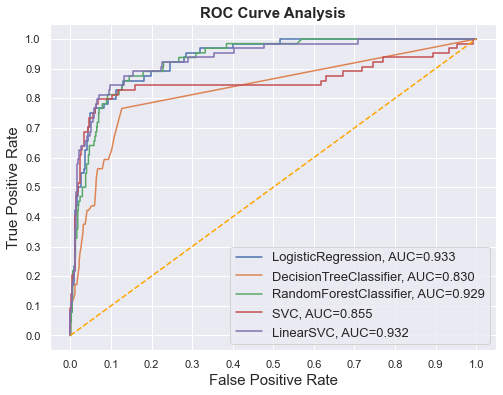

In [142]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

## <Center><u> CONCLUSION </center></u>

## Reflection

### Introducing the problem, the domain and a potential solution
The process developed in this research took a raw data set filled with customer information and turned it into a predictive analysis regarding customer lifetime value. The research was split into several parts.  It starts with an introduction that states additional background information and gives an overview about recent research about employee turnover. In this part the problem and a possible solution is also stated . We have also referred to multiple research papers to gain more insights on the existing solutions and how much it can be improved. An interesting takeaway from this part was the complexity of the domain and various multi- layered approaches that have been executed in the search of workable solutions.

### Exploring the data and its peculiarities
First we start with making ourselves familiar with the database by performing inital analysis. The insights gained through this step will be helpful in directing which direction the project must steer towards.
Afterwards an in-depth analysis of the data took place. Starting with data exploration and proceeded with identifying the individual traits of the data set. This section highlighted the importance of context, when it comes to a human related topic. Understanding the context and inter relationship of the variables is just as important as creating a prediction algorithm . 

### Thoughts on models and algorithms
After establishing theoretical and topical groundwork, several machine learning solutions were explored. Starting with a collection of supervised and unsupervised algorithms that could potentially lead to a successful solution and their in- tuition were mentioned. This segment tried to give a brief introduction into the criterias and upsides which led to a set of algorithms. A major takeaway was the complexity of combining supervised and unsupervised sets especially when dealing with a mix of variable classes. Since it’s not that easy to apply clustering algorithms to a mix of continuous and discrete variables a compromise had to be found. Another important takeaway was the discussion about prediction scoring. Adding scoring to the mix increased the reliability of the results.

### Exploring methods for handling the data
In the next segment the methodology behind handling the data and dealing with its detected peculiarities was discussed. From data preprocessing with steps such as missing value, removing duplicates, assigning right types to values or outlier detection and handling as well as feature normalization .

### Implementing a solution
The implementation phase was split into three prediction and two refinement runs. Combining efforts of unsupervised and supervised learning algorithms this segment tried to put into action what was introduced in the solution statement. Before starting with the first prediction, 20% of the data was set aside for testing. For all supervised learning algorithms stratified 5-fold cross-validation was performed in an attempt to create an algorithm that would generalize well on new data. First it started with a basic implementation of the supervised learning algorithms. Afterwards an unsupervised learning algorithm was implemented to find clusters and additional relationships in the data. The cluster labels were added to the data set and another run of prediction took place.Rock_curve_analysis has also been performed for all the model


### Success of the model
The final model and solution does fit the expectation stated in the beginning. Yet it is important to point out that this solution is tied to the present data set. With a data set that is more noisy the problem of generalization as mentioned in some of the presented literature may occur especially when dealing with tree-based algorithms that don’t implement pruning. The solution presented here could be used in a general setting to determine not only customer lifetime value but also feature relevance in companies with a certain size and reporting structure.

## Improvement
There are a few suggestions to improve this research that would go beyond the scope of this analysis.

### More and more diverse data
The available information for this research has its limitations. Although the data was nice to handle and exceptionally clean from the beginning there were some aspects that felt could use improvements. In an attempt to get more insights a follow up research could start pulling additional information from a variety of sources, gather more granular splits on some of the existing variables or try to reverse engineer some information that might be hidden in the data set. 


### Computational Efficiency 
Some of the parts in this research are computationally expensive. Especially computing the silhouette score with a broad variety of parameter settings can take a long time to process. An implementation of this research should focus on parallel computing which is not only possible for specific segments but also for tree-based algorithms such as Random Forest. 




<center> End of Document <center>
    
<center> Submitted by Gayathri Sundareshwar, Keerthana Gopikrishnan and Razan Dababo<center>
<Center> April 4th 2022 <center>